# Задача 4. Ансамбли

1. Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
3. Самостоятельно реализуйте алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
4. Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).
5. При обучении использовать подбор гиперпараметров, кросс-валидацию.
6. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
7. (+2 балла) Также добавить в сравнение модели из библиотек XGBoost, LightGBM и CatBoost.
8. (+3 балла) Для подбора гиперпараметров использовать фреймворк Optuna.

Выполнил все задания: гиперпараметры подбирал при помощи Optuna, в сравнение добавил алгоритмы XGBoost, LightGBM и CatBoost.

## 1. Данные

Был взять датасет "Body performance Data", который доступен по [ссылке](https://www.kaggle.com/datasets/kukuroo3/body-performance-data?resource=download).

Датасет состоит из 12 признаков:
1. Возраст
2. Пол (М/Ж)
3. Рост (см)
4. Вес (кг)
5. Процент жира 
6. Диастолическое артериальное давление
7. Систолическое артериальное давление
8. Сила захвата
9. Наклон из положения сидя (см)
10. Количество приседаний
11. Прыжок в длину (см)
12. Класс (A -- лучший, B, C, D) -- целевой признак.

In [567]:
import pandas as pd
data = pd.read_csv('bodyPerformance.csv', sep=',')

data.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


В датасете присутствует 13 393 записи.

In [568]:
data.shape

(13393, 12)

## 2. Разведочный анализ (EDA)

In [569]:
data.dtypes

age                        float64
gender                      object
height_cm                  float64
weight_kg                  float64
body fat_%                 float64
diastolic                  float64
systolic                   float64
gripForce                  float64
sit and bend forward_cm    float64
sit-ups counts             float64
broad jump_cm              float64
class                       object
dtype: object

Все признаки, кроме целевого и признака "Пол", являются числовыми.

In [570]:
data.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

Датасет "хороший" в том смысле, что в нём нет пропусков в данных.

In [571]:
data['gender'].value_counts()

M    8467
F    4926
Name: gender, dtype: int64

Переведём признак "Пол" в числовой (0 -- женщина, 1 -- мужчина).

In [572]:
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

Переведём целевой признак в числовой (A -- 0, B -- 1, C -- 2, D -- 3).

In [573]:
data['class'] = data['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

In [574]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot: >

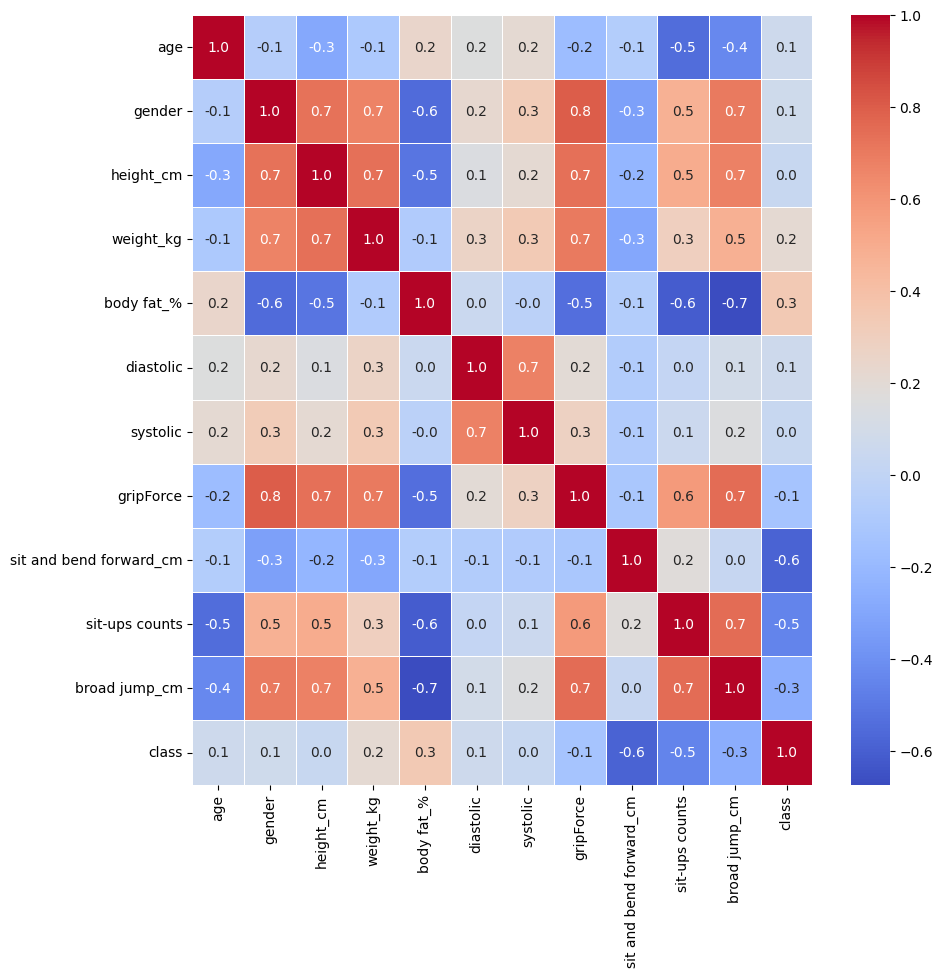

In [575]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5, cmap='coolwarm')

Некоторые выводы по корреляции признаков:
- Признаки "Рост" и "Вес" имеют сильную корреляцию (что вполне логично), также с ними сильно коррелирует признак "Сила захвата".
- Также коррелируют показатели различного давления.
- Признак "Прыжок в длину" сильно коррелирует с "Силой захвата" и "Количеством приседаний" (видимо, спортивные люди делают все спортивные управления лучше, а не какое-то одно).
- Также показательно, что признак "Процент жира" слабо коррелирует с признаками "Рост" и "Вес".
- Видно, что признак "Сила захвата" сильно зависит от признака "Пол" (неудевително, т.к. мужчины в среднем сильнее женщин).

In [576]:
data.groupby('class').count()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
class,,,,,,,,,,,
0,3348,3348,3348,3348,3348,3348,3348,3348,3348,3348,3348
1,3347,3347,3347,3347,3347,3347,3347,3347,3347,3347,3347
2,3349,3349,3349,3349,3349,3349,3349,3349,3349,3349,3349
3,3349,3349,3349,3349,3349,3349,3349,3349,3349,3349,3349


Видим, что данных поровну объектов в каждом классе, что позволяет считать, что классы сбалансированы.

In [577]:
data.groupby('class').mean()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
class,,,,,,,,,,,
0,35.268220,0.556750,167.871027,64.418178,20.539159,77.903345,129.290024,38.615723,21.391777,47.848268,202.744026
1,37.074096,0.645952,168.580311,66.612420,22.039981,78.656468,130.639349,37.910436,17.467586,42.639199,195.332566
2,36.699612,0.667961,169.162168,66.760314,22.644564,78.550672,129.925351,36.582663,14.390645,38.720215,188.627949
3,38.058226,0.658107,168.625530,71.996948,27.735432,80.076530,131.084503,34.747746,7.590260,29.881338,173.820842


Можно заметить:
- Средний возраст "хороших" спортсменов -- 35 лет.
- Процент жира у "хороших" спортсменов в среднем ниже, чем у "плохих", причем значительно.
- В среднем "хорошие" спортсмены весят меньше.
- И очевидно, что они дальше прыгают, большое могут присесть, у них выше сила захвата.

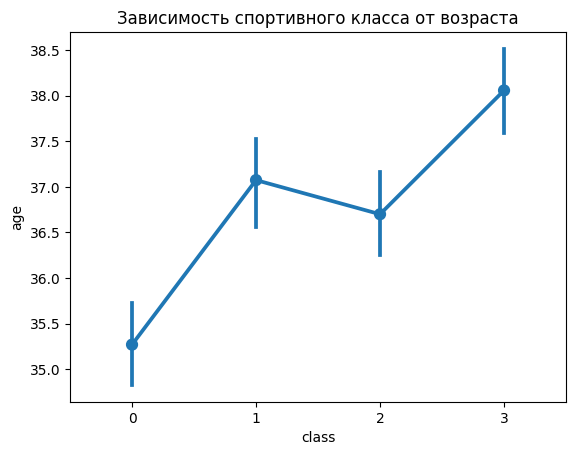

In [578]:
sns.pointplot(y="age", x="class", data=data)
plt.title('Зависимость спортивного класса от возраста')
plt.show()

Можно заметить:
- Средний возраст для "хороших" спортсменов -- 35 лет.
- После 35 лет показатели спортсменов начинают падать.

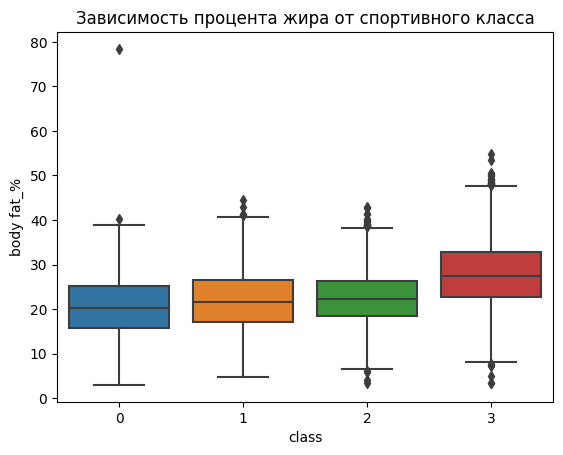

In [579]:
sns.boxplot(x="class", y="body fat_%", data=data)
plt.title('Зависимость процента жира от спортивного класса')
plt.show()

В среднем у "хороших" спортсменов процент жира в теле меньше, чем у других.

In [580]:
data.corr()['class'].sort_values(ascending=False)


class                      1.000000
body fat_%                 0.341956
weight_kg                  0.214129
gender                     0.075605
diastolic                  0.066761
age                        0.065612
height_cm                  0.037753
systolic                   0.035484
gripForce                 -0.136088
broad jump_cm             -0.262154
sit-ups counts            -0.452832
sit and bend forward_cm   -0.588123
Name: class, dtype: float64

Выводы по корреляции целевого признака с остальными:
- Признаки body fat_% и weight_kg имеют положительную корреляцию с целевым признаком class, что может указывать на то, что люди с более высоким процентом жира или весом более склонны к определенному классу.
- Признак sit-ups counts имеет отрицательную корреляцию с целевым признаком class, что может указывать на то, что люди с более низким количеством выполненных подъемов туловища имеют большую вероятность попасть в другой класс.
-  Признак sit and bend forward_cm также имеет сильную отрицательную корреляцию с целевым признаком class, что может указывать на то, что люди, которые не могут согнуться на большое расстояние вперед, более склонны к определенному классу.
- Признак broad jump_cm также имеет отрицательную корреляцию с целевым признаком class, что может указывать на то, что люди с более мелким прыжком имеют большую вероятность попасть в другой класс.

## 3. Алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.

In [581]:
from sklearn.utils import resample
import numpy as np

class MyBaggingClassifier:
    def __init__(self, n_estimators=10, max_samples=1.0, max_features=1.0, base_estimator=None):
        self.n_estimators = n_estimators            # Number of aglorythms in the ensemble
        self.max_samples = max_samples              # Proportion of objects that are used in the training of each algorithm
        self.max_features = max_features            # Proportion of features that are used in the training of each algorithm
        self.estimators = []                        # List of algorithms in the ensemble
        self.base_estimator = base_estimator        # Base algorithm

    def fit(self, X, y):
        for i in range(self.n_estimators):
            # Selection of random objects from the training sample
            X_resampled, y_resampled = resample(X, y, n_samples=int(self.max_samples * len(X)), replace=False)

            # Selection of random features from the feature matrix
            features_indices = np.random.choice(X.shape[1], int(self.max_features * X.shape[1]), replace=False)

            # Training on a random subsample
            self.base_estimator.fit(X_resampled[:, features_indices], y_resampled)

            # Adding the trained algorithm to the ensemble list
            self.estimators.append((self.base_estimator, features_indices))

    def predict(self, X):
        # Class prediction
        y_pred = np.zeros((X.shape[0], len(np.unique(y))))
        for estimator, features_indices in self.estimators:
            y_pred += estimator.predict_proba(X[:, features_indices])
        return np.argmax(y_pred, axis=1)

In [582]:
class MyAdaBoostClassifier:
    def __init__(self, n_estimators=50, learning_rate=1, base_estimator=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        self.estimator_weights = np.zeros(n_estimators)
        self.estimator_errors = np.zeros(n_estimators)
        self.base_estimator = base_estimator

    def fit(self, X, y):
        # Initialize weights to 1/N
        w = np.ones(len(X)) / len(X)
        
        for i in range(self.n_estimators):
            # Train a weak learner
            self.base_estimator.fit(X, y, sample_weight=w)

            # Calculate the weighted error of the estimator
            y_pred = self.base_estimator.predict(X)
            incorrect = y_pred != y
            estimator_error = np.sum(w[incorrect])
            self.estimator_errors[i] = estimator_error

            # Calculate the weight of the estimator
            if estimator_error <= 0:
                self.estimator_weights[i] = 1
            else:
                self.estimator_weights[i] = self.learning_rate * np.log((1 - estimator_error) / estimator_error)

            # Update the weights
            w *= np.exp(self.estimator_weights[i] * incorrect * ((w > 0) | (self.estimator_weights[i] < 0)))

            # Normalize the weights
            w /= np.sum(w)

            # Save the estimator
            self.estimators.append(self.base_estimator)

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators, 'learning_rate': self.learning_rate}

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, estimator in enumerate(self.estimators):
            y_pred += self.estimator_weights[i] * estimator.predict(X)
        return np.sign(y_pred)

## 4. Обучение ансамблей для простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).

In [583]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

X = data.drop('class', axis=1).values
y = data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Будем подбирать гиперпараметры при помощи фреймворка Optuna, а также считать время, которое требуется для обучения модели.

Обучение ансамблей деревьев принятия решений для моей реализации Bagging.

In [584]:
# Подбор гиперпараметров при помощи Optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    z = trial.suggest_int('z', 2, 12)
    bagging = MyBaggingClassifier(n_estimators=x, max_samples=y/100, max_features=z/12, base_estimator=DecisionTreeClassifier())
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
my_bagging_accuracy = study.best_value

x_best = study.best_trial.params['x']
y_best = study.best_trial.params['y']
z_best = study.best_trial.params['z']

Number of finished trials: 20
Best trial: {'x': 35, 'y': 74, 'z': 12}
Accuracy: 0.4146341463414634


In [585]:
myBagging = MyBaggingClassifier(n_estimators=x_best, max_samples=y_best/100, max_features=z_best/12, base_estimator=DecisionTreeClassifier())

start_time = time.time()
myBagging.fit(X_train, y_train)
end_time = time.time()

myBagging_y_pred = myBagging.predict(X_test)
myBaggindAccuracy = accuracy_score(y_test, myBagging_y_pred)
myBaggingTime = end_time - start_time

Обучение ансамблей деревьев принятия решений для реализации Bagging из sklearn.

In [586]:
from sklearn.ensemble import BaggingClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    z = trial.suggest_int('z', 2, 12)
    bagging = BaggingClassifier(n_estimators=x, max_samples=y/100, max_features=z/12, base_estimator=DecisionTreeClassifier())
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
sklearn_bagging_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']
z = study.best_trial.params['z']

Number of finished trials: 20
Best trial: {'x': 100, 'y': 67, 'z': 12}
Accuracy: 0.7456445993031359


In [587]:
sklearnBagging = BaggingClassifier(n_estimators=x, max_samples=y/100, max_features=z/12, base_estimator=DecisionTreeClassifier())

start_time = time.time()
sklearnBagging.fit(X_train, y_train)
end_time = time.time()

sklearnBagging_y_pred = sklearnBagging.predict(X_test)
sklearnBaggingAccuracy = accuracy_score(y_test, sklearnBagging_y_pred)
sklearnBaggingTime = end_time - start_time

Обучение ансамблей деревьев принятия решений для моей реализации AdaBoost.

In [588]:
def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    bagging = MyAdaBoostClassifier(n_estimators=x, learning_rate=y, base_estimator=DecisionTreeClassifier())
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
my_adaboost_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']

Number of finished trials: 20
Best trial: {'x': 45, 'y': 45}
Accuracy: 0.37207565953210553


In [589]:
myAdaBoost = MyAdaBoostClassifier(n_estimators=x, learning_rate=y, base_estimator=DecisionTreeClassifier())

start_time = time.time()
myAdaBoost.fit(X_train, y_train)
end_time = time.time()

myAdaBoost_y_pred = myAdaBoost.predict(X_test)
myAdaBoostAccuracy = accuracy_score(y_test, myAdaBoost_y_pred)
myAdaBoostTime = end_time - start_time

Обучение ансамблей деревьев принятия решений для реализации AdaBoost из sklearn. 

In [590]:
from sklearn.ensemble import AdaBoostClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    bagging = AdaBoostClassifier(n_estimators=x, learning_rate=y, base_estimator=DecisionTreeClassifier())
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
sklearn_adaboost_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']

Number of finished trials: 20
Best trial: {'x': 55, 'y': 84}
Accuracy: 0.646590343454455


In [591]:
sklearnAdaBoost = AdaBoostClassifier(n_estimators=x, learning_rate=y, base_estimator=DecisionTreeClassifier())

start_time = time.time()
sklearnAdaBoost.fit(X_train, y_train)
end_time = time.time()

sklearnAdaBoost_y_pred = sklearnAdaBoost.predict(X_test)
sklearnAdaBoostAccuracy = accuracy_score(y_test, sklearnAdaBoost_y_pred)
sklearnAdaBoostTime = end_time - start_time

Обучение ансамблей деревьев принятия решений для реализации Random Forest из sklearn.

In [592]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    z = trial.suggest_int('z', 2, 12)
    rf = RandomForestClassifier(n_estimators=x, max_samples=y/100, max_features=z/12, max_depth=3, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
sklearn_rf_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']
z = study.best_trial.params['z']

Number of finished trials: 20
Best trial: {'x': 74, 'y': 98, 'z': 8}
Accuracy: 0.6167247386759582


In [593]:
sklearnRF = RandomForestClassifier(n_estimators=x, max_samples=y/100, max_features=z/12, max_depth=3, random_state=42)

start_time = time.time()
sklearnRF.fit(X_train, y_train)
end_time = time.time()

sklearnRF_y_pred = sklearnRF.predict(X_test)
sklearnRFAccuracy = accuracy_score(y_test, sklearnRF_y_pred)
sklearnRFTime = end_time - start_time

Обучение Gradient Tree Boosting из sklearn.

In [594]:
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    z = trial.suggest_int('z', 2, 12)
    gb = GradientBoostingClassifier(n_estimators=x, max_depth=y, max_features=z/12, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
sklearn_gradient_boosting_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']
z = study.best_trial.params['z']

Number of finished trials: 20
Best trial: {'x': 100, 'y': 6, 'z': 7}
Accuracy: 0.75311100049776


In [595]:
sklearnGB = GradientBoostingClassifier(n_estimators=x, max_depth=y, max_features=z/12, random_state=42)

start_time = time.time()
sklearnGB.fit(X_train, y_train)
end_time = time.time()

sklearnGB_y_pred = sklearnGB.predict(X_test)
sklearnGBAccuracy = accuracy_score(y_test, sklearnGB_y_pred)
sklearnGBTime = end_time - start_time

Обучение Histogram-Based Gradient Boosting из sklearn.

In [596]:
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    hgbc = HistGradientBoostingClassifier(max_iter=x, max_depth=y, random_state=42)
    hgbc.fit(X_train, y_train)
    y_pred = hgbc.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
sklearn_hist_gradient_boosting_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']

Number of finished trials: 20
Best trial: {'x': 69, 'y': 43}
Accuracy: 0.7727725236436038


In [597]:
sklearnHGB = HistGradientBoostingClassifier(max_iter=x, max_depth=y, random_state=42)

start_time = time.time()
sklearnHGB.fit(X_train, y_train)
end_time = time.time()

sklearnHGB_y_pred = sklearnHGB.predict(X_test)
sklearnHGBAccuracy = accuracy_score(y_test, sklearnHGB_y_pred)
sklearnHGBTime = end_time - start_time

Обучение XGBClassifier из XGBoost.

In [598]:
from xgboost import XGBClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    xgb = XGBClassifier(n_estimators=x, max_depth=y, random_state=42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
xgboost_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']

Number of finished trials: 20
Best trial: {'x': 83, 'y': 69}
Accuracy: 0.7565953210552514


In [599]:
xgb = XGBClassifier(n_estimators=x, max_depth=y, random_state=42)

start_time = time.time()
xgb.fit(X_train, y_train)
end_time = time.time()

xgb_y_pred = xgb.predict(X_test)
xgbAccuracy = accuracy_score(y_test, xgb_y_pred)
xgbTime = end_time - start_time

Обучение LGBMClassifier из LightGBM.

In [600]:
from lightgbm import LGBMClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 100)
    lgbm = LGBMClassifier(n_estimators=x, max_depth=y, random_state=42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
lightgbm_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']

Number of finished trials: 20
Best trial: {'x': 75, 'y': 75}
Accuracy: 0.7732702837232454


In [601]:
lgbm = LGBMClassifier(n_estimators=x, max_depth=y, random_state=42)

start_time = time.time()
lgbm.fit(X_train, y_train)
end_time = time.time()

lgbm_y_pred = lgbm.predict(X_test)
lgbmAccuracy = accuracy_score(y_test, lgbm_y_pred)
lgbmTime = end_time - start_time

Обучение CatBoostClassifier из CatBoost.

In [602]:
from catboost import CatBoostClassifier

def objective(trial):
    x = trial.suggest_int('x', 1, 100)
    y = trial.suggest_int('y', 1, 16)
    cat = CatBoostClassifier(n_estimators=x, max_depth=y, random_state=42, verbose=False)
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Accuracy:', study.best_value)
catboost_accuracy = study.best_value

x = study.best_trial.params['x']
y = study.best_trial.params['y']

Number of finished trials: 20
Best trial: {'x': 87, 'y': 7}
Accuracy: 0.7349427575908413


In [603]:
cat = CatBoostClassifier(n_estimators=x, max_depth=y, random_state=42, verbose=False)

start_time = time.time()
cat.fit(X_train, y_train)
end_time = time.time()

cat_y_pred = cat.predict(X_test)
catAccuracy = accuracy_score(y_test, cat_y_pred)
catTime = end_time - start_time

## 5. Сравнение результатов

In [604]:
data = {'Accuracy': [myBaggindAccuracy, sklearnBaggingAccuracy, myAdaBoostAccuracy, sklearnAdaBoostAccuracy, sklearnGBAccuracy, sklearnHGBAccuracy, sklearnRFAccuracy, xgbAccuracy, lgbmAccuracy, catAccuracy],
        'Time': [myBaggingTime, sklearnBaggingTime, myAdaBoostTime, sklearnAdaBoostTime, sklearnGBTime, sklearnHGBTime, sklearnRFTime, xgbTime, lgbmTime, catTime]}
df = pd.DataFrame(data, index=['MyBagging', 'sklearnBagging', 'MyAdaBoost', 'sklearnAdaBoost', 'Gradient Boost', 'Histogram-Based GB', 'Random forest', 'XGBoost', 'LightGBM', 'CatBoost'])

df

,Accuracy,Time
MyBagging,0.273270,1.248377
sklearnBagging,0.734196,2.406292
MyAdaBoost,0.368094,2.315814
sklearnAdaBoost,0.641115,0.052645
Gradient Boost,0.753111,5.670517
Histogram-Based GB,0.772773,4.364327
Random forest,0.616725,0.449139
XGBoost,0.756595,4.167935
LightGBM,0.773270,0.811584
CatBoost,0.734943,0.454835


Выводы:
- Мои реализации оказались хуже, чем библиотечные. 
- Bagging сильно хуже, AdaBoost просто хуже :)
- Зато моя реализация алгоритма Bagging быстрее обучается
- Если сравнивать остальные алгоритмы, то лучше всего себя показали алгоритмы семеста Gradient Boosting
- Дольше всех обучается Gradient Boosting из sklearn.

Построим матрицы ошибок

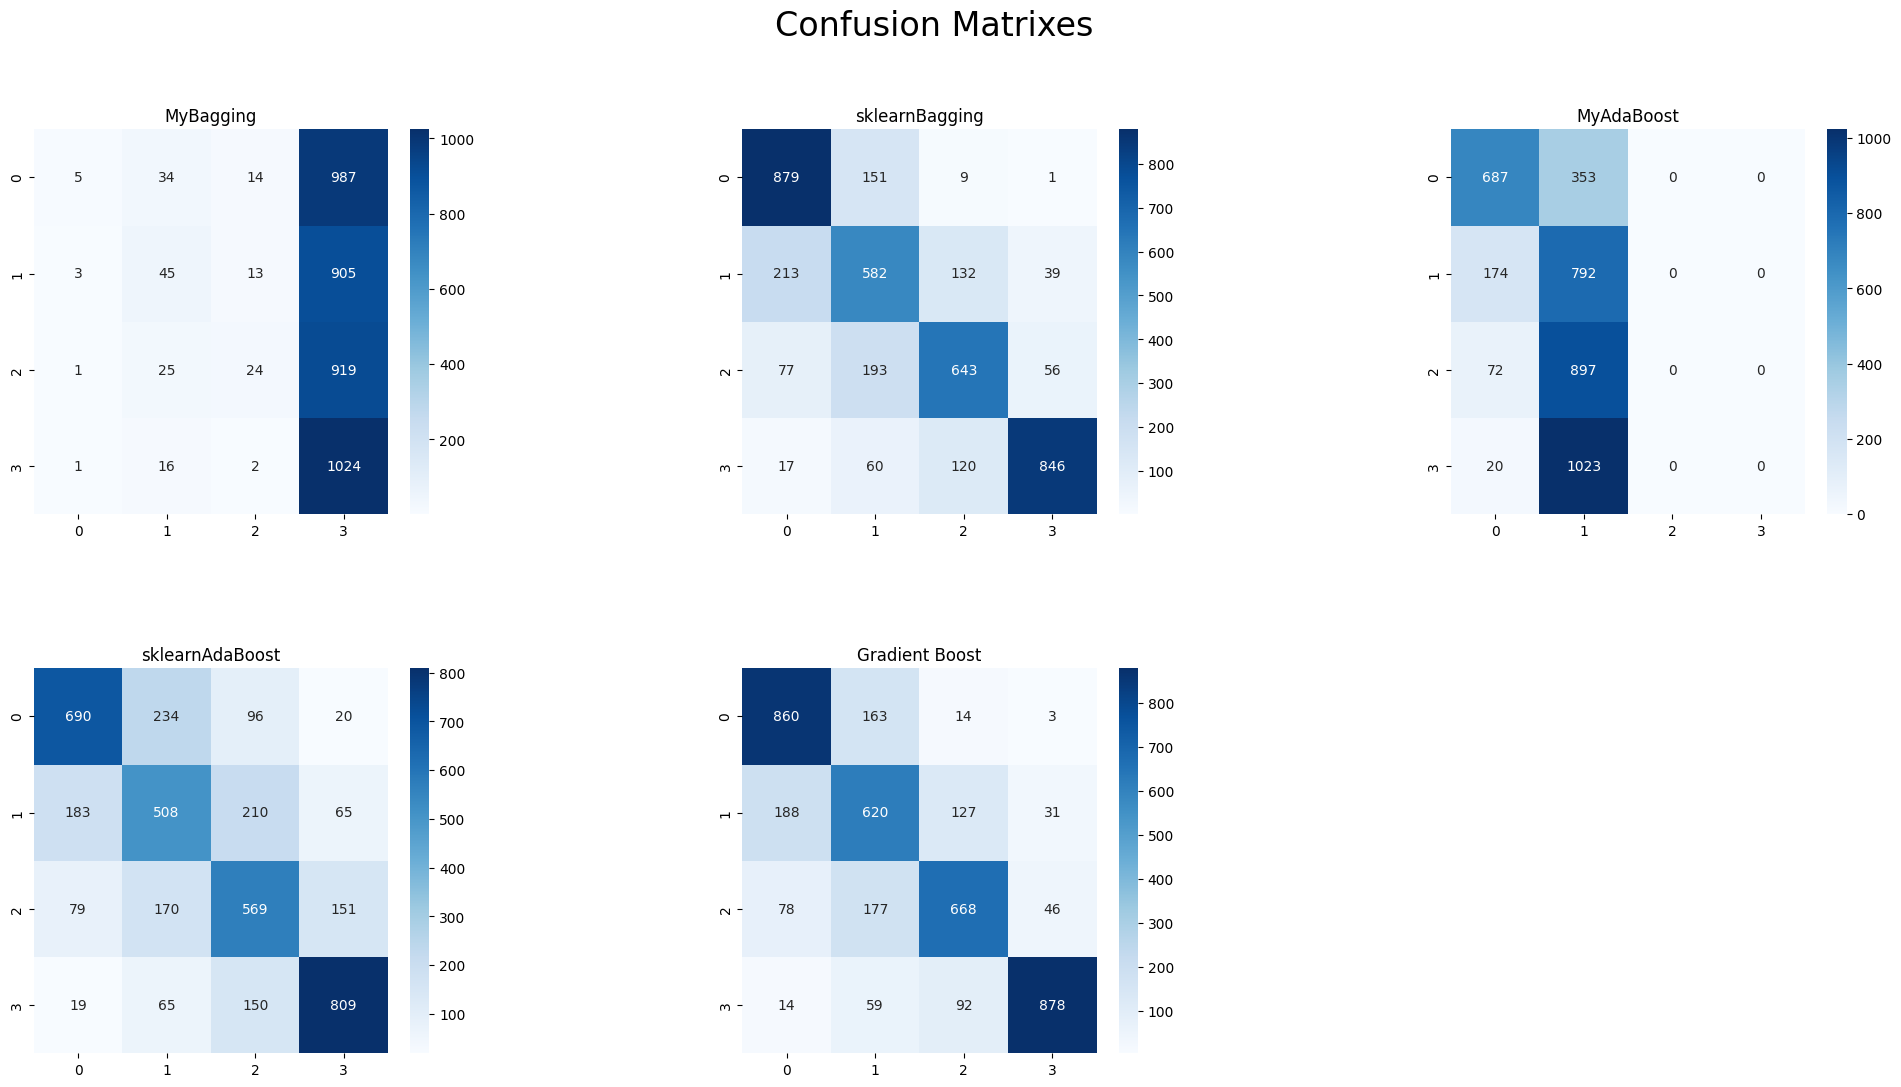

In [605]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2, 3, 1)
plt.title("MyBagging")
sns.heatmap(confusion_matrix(y_test, myBagging_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 2)
plt.title("sklearnBagging")
sns.heatmap(confusion_matrix(y_test, sklearnBagging_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 3)
plt.title("MyAdaBoost")
sns.heatmap(confusion_matrix(y_test, myAdaBoost_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 4)
plt.title("sklearnAdaBoost")
sns.heatmap(confusion_matrix(y_test, sklearnAdaBoost_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 5)
plt.title("Gradient Boost")
sns.heatmap(confusion_matrix(y_test, sklearnGB_y_pred), annot=True, fmt="d", cmap="Blues")

plt.show()

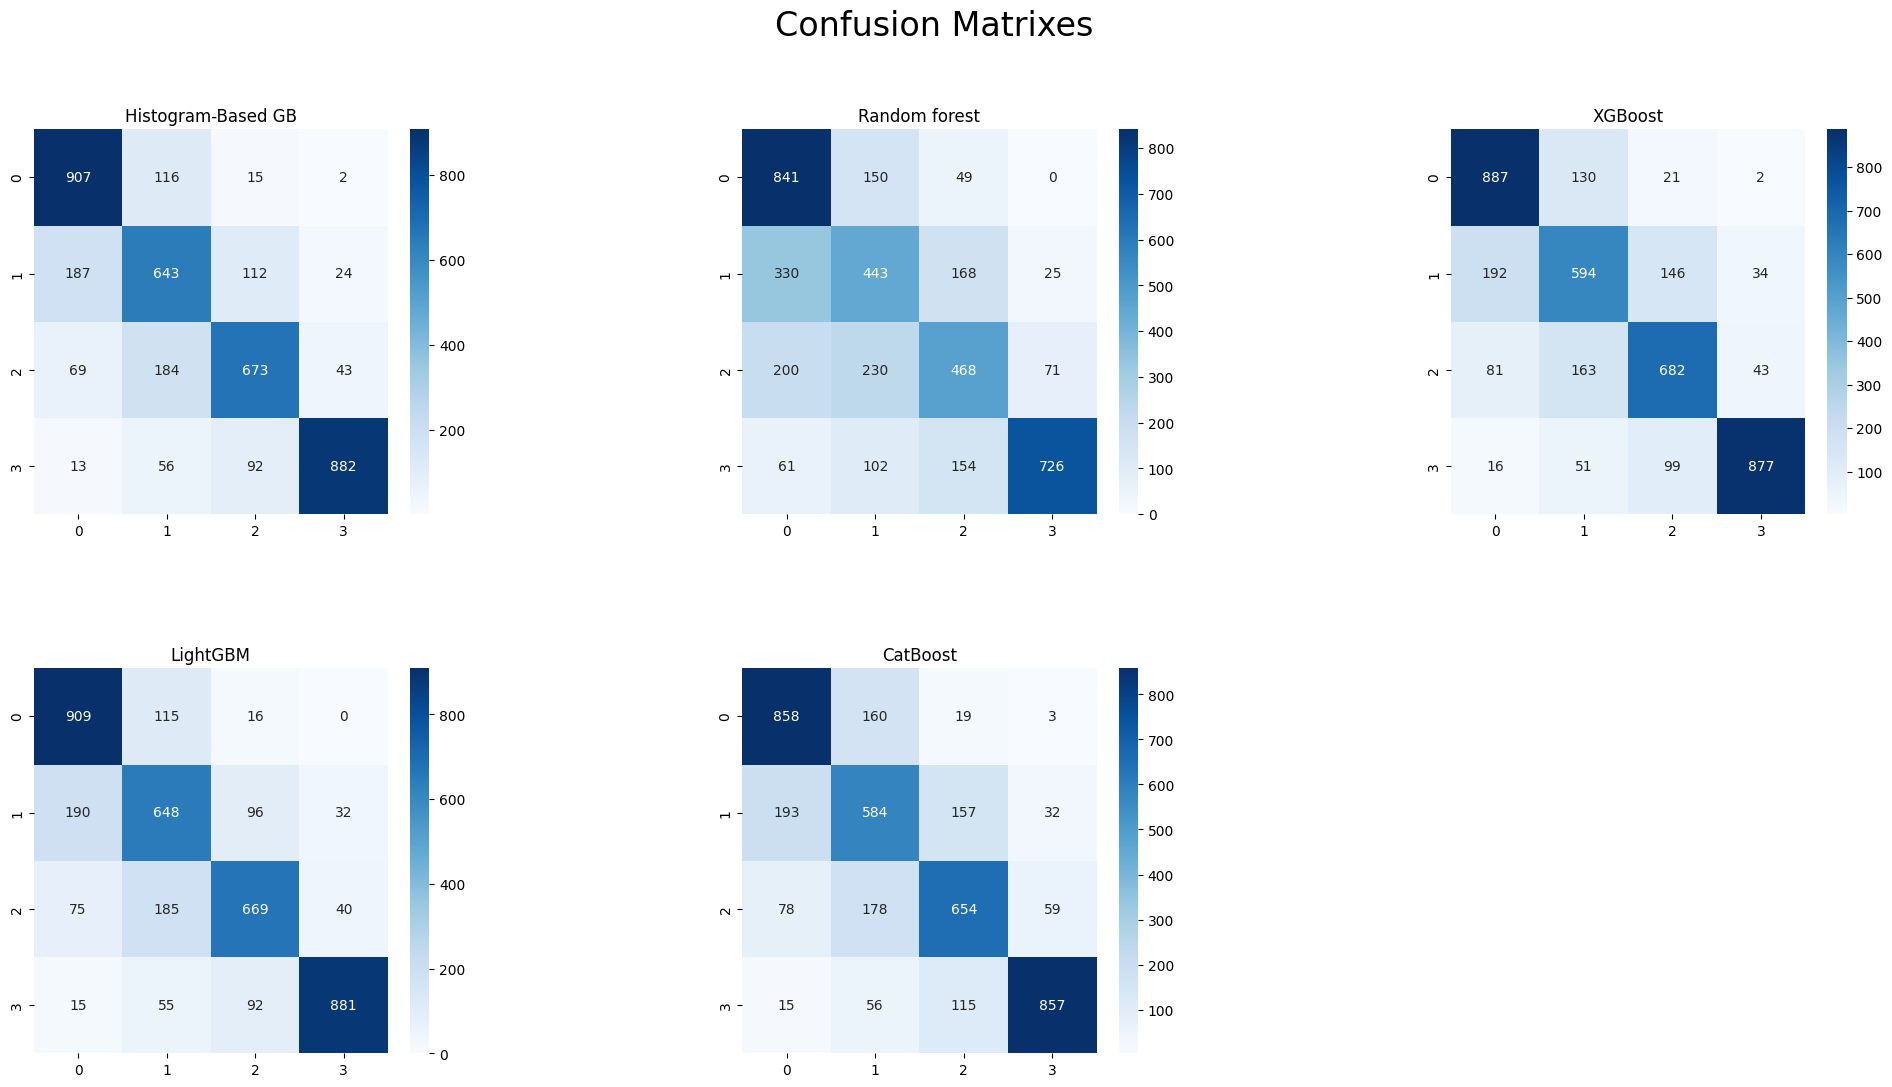

In [606]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2, 3, 1)
plt.title("Histogram-Based GB")
sns.heatmap(confusion_matrix(y_test, sklearnHGB_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 2)
plt.title("Random forest")
sns.heatmap(confusion_matrix(y_test, sklearnRF_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 3)
plt.title("XGBoost")
sns.heatmap(confusion_matrix(y_test, xgb_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 4)
plt.title("LightGBM")
sns.heatmap(confusion_matrix(y_test, lgbm_y_pred), annot=True, fmt="d", cmap="Blues")

plt.subplot(2, 3, 5)
plt.title("CatBoost")
sns.heatmap(confusion_matrix(y_test, cat_y_pred), annot=True, fmt="d", cmap="Blues")

plt.show()

- Из матриц ошибок видно, что библиотечные реализации алгоритмов все +/- похожи.
- Моя реализация Bagging почти всегда предсказывает класс 3
- А AdaBoost почти всегда предсказывает класс 1